V1 includes:

- For IRR: calculating future IRRs based on targets

- For MOIC: adding graph of target and value of Break even (P&I based on 10% a year)

# MANUAL: the amount of months to show. Based on 
https://docs.google.com/presentation/d/1MH-i5XG6ZjZqyGqK3Kbbq010dIYsiKJr6N5nhFU1im4/edit#slide=id.g310ab6fca0a_0_0

In [3]:
import os
import sys
import pandas as pd
import datetime
import numpy as np
import warnings
warnings.filterwarnings('ignore') 
#import xlsxwriter
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [4]:
import pandas_gbq
import numpy_financial as npf

## Variable for all books

In [6]:
annual_interest_rate =0.15
factor_ak_loan=0.75

## Multitude AU Oct 21

In [8]:
###Manual:
book_id='3435712288'
num_values=35 #amount cohort with actual

In [9]:
query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)

In [10]:
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=ghuM67Oug0btcBs0bjNOiDAME0U7tZ&prompt=consent&access_type=offline
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


In [11]:
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,coalesce(round(sum(actual_amount),2),0) actual_amount, coalesce(round(sum(actual_amount_usd),2),0) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null -- and actual_amount is not null
order by month_cohort'''.format(book_id)

In [12]:
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


In [13]:
book_name=df_cf.iloc[0,1]

In [14]:
### MOIC Calculation

In [15]:
cashflow=df_cf['actual_amount'].tolist()

In [16]:
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 

In [17]:
#### Calculating Dynamic MOIC based on target

In [18]:
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 

In [19]:
####Adding Value of P&I

In [20]:
price= purchase_value.copy()

In [21]:
monthly_rate = ((1+annual_interest_rate )**(1/12))-1

In [22]:
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)

In [23]:
monthly_payments=monthly_payments.tolist()

In [24]:
remaining_balance = price
data = []

In [25]:
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

In [26]:
first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]

In [27]:
first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])

In [28]:
### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

In [29]:
####Calculting IRR

In [30]:
df_irr_actual=df_cf['actual_amount'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()

In [31]:
num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    new_list = df_irr_actual[:i] + df_irr_target[i:]
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

In [32]:
###Adding purchase as negative number

In [33]:
fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)  

In [34]:
#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr 

In [35]:
### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

In [36]:
df_cf['irr_yearly']=irr_yearly 

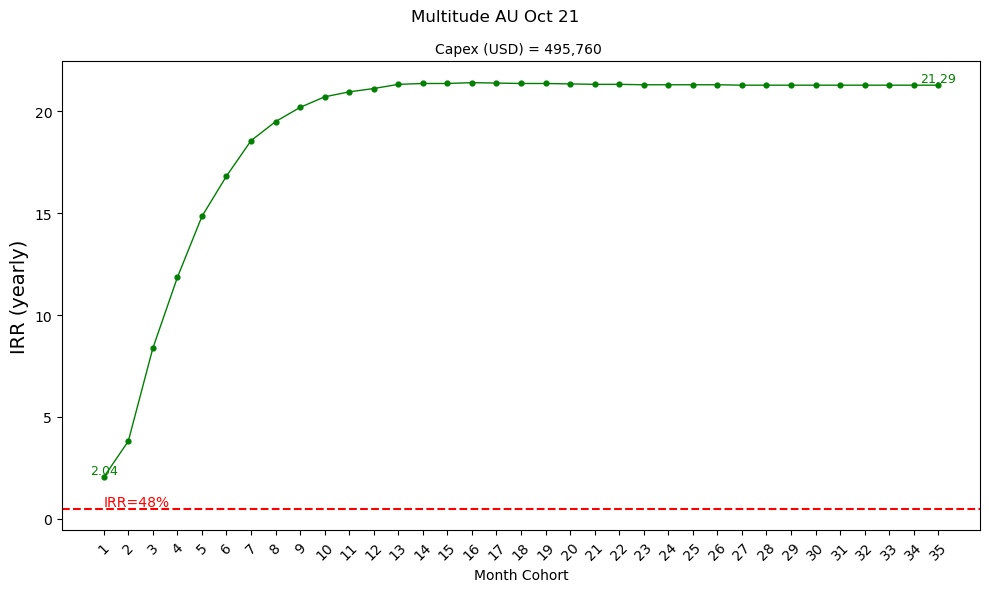

In [37]:
plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('IRR (yearly)', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Rotate x-axis labels for better readability (optional)
plt.xticks(df_cf['month_cohort'][:num_values], rotation=45)

# Annotate each point with its y-value (optional)
# for i, value in enumerate(df_cf['irr_yearly'][:num_values]):
#     plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#              f'{value:,.2f}', ha='center', va='bottom', fontsize=9)

# Get the last value within the limited range for annotation
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['irr_yearly'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
#plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
#plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)

# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48 * 1E-2, color='red', linestyle='--', label='y = 3.32%')
plt.text(df_cf['month_cohort'].min(), 48 * 1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()

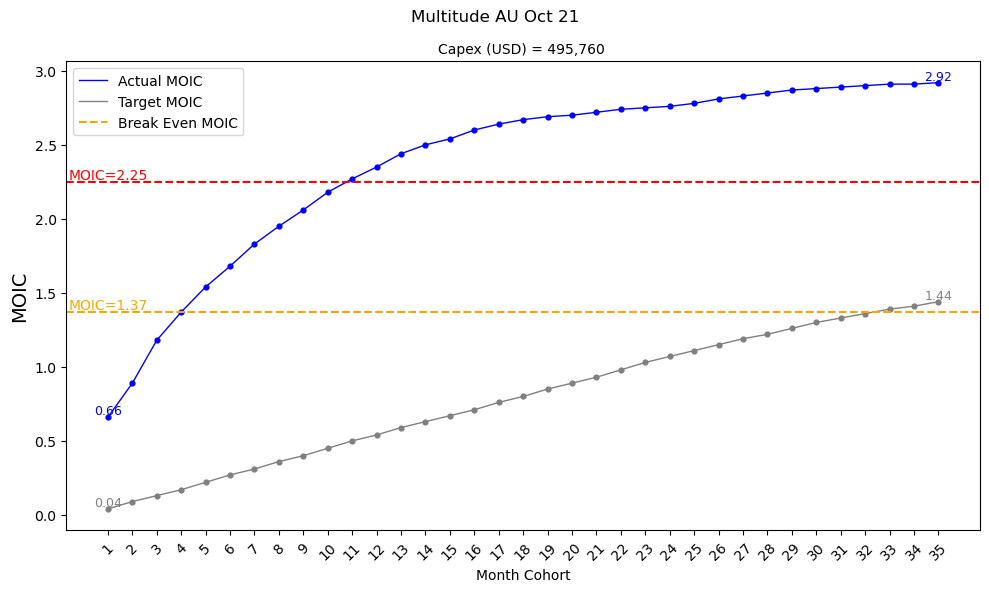

In [38]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', s=12)
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks for only the selected range
ticks = df_cf['month_cohort'][:num_values]
plt.xticks(ticks, rotation=45)

# Annotate last point with its y-value within the limited range
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['moic'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate target MOIC last point within the limited range
last_y_target = df_cf['moic_target'][:num_values].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Annotate target MOIC first point
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()


In [39]:
### MOIC Break even target

monthly_payments = round(df_cf['target_prediction_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []


df_loan_target=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan_target = pd.DataFrame(data)


first_negative_balance_target = df_loan_target[df_loan_target["remaining_balance"] < 0].iloc[0]

first_negative_balance_cohort_month_target = int(first_negative_balance_target["cohort_month"])
moic_break_even_target = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month_target, 'moic_target'].values[0]

print('cohort month moic break even target: ',first_negative_balance_cohort_month_target )
print('value of moic break even target: ',moic_break_even_target)

cohort month moic break even target:  46
value of moic break even target:  1.68


## Primagas ES Jan 2023

In [172]:
###Manual:
book_id='3791494045'
num_values=14 #amount cohort with actual

In [174]:
query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,coalesce(round(sum(actual_amount),2),0) actual_amount, coalesce(round(sum(actual_amount_usd),2),0) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null -- and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

####Calculting IRR
df_irr_actual=df_cf['actual_amount'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    new_list = df_irr_actual[:i] + df_irr_target[i:]
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly 

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


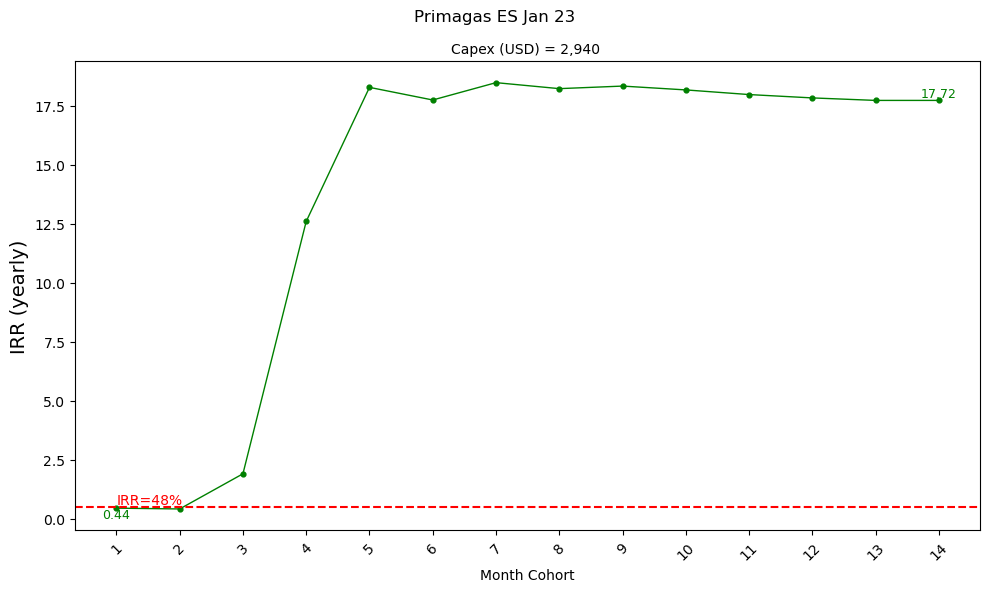

In [175]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('IRR (yearly)', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Rotate x-axis labels for better readability (optional)
plt.xticks(df_cf['month_cohort'][:num_values], rotation=45)

# Annotate each point with its y-value (optional)
# for i, value in enumerate(df_cf['irr_yearly'][:num_values]):
#     plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#              f'{value:,.2f}', ha='center', va='bottom', fontsize=9)

# Get the last value within the limited range for annotation
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['irr_yearly'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='top', fontsize=9, color='green')

# Add a line where y = 0
#plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
#plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)

# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48 * 1E-2, color='red', linestyle='--', label='y = 3.32%')
plt.text(df_cf['month_cohort'].min(), 48 * 1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


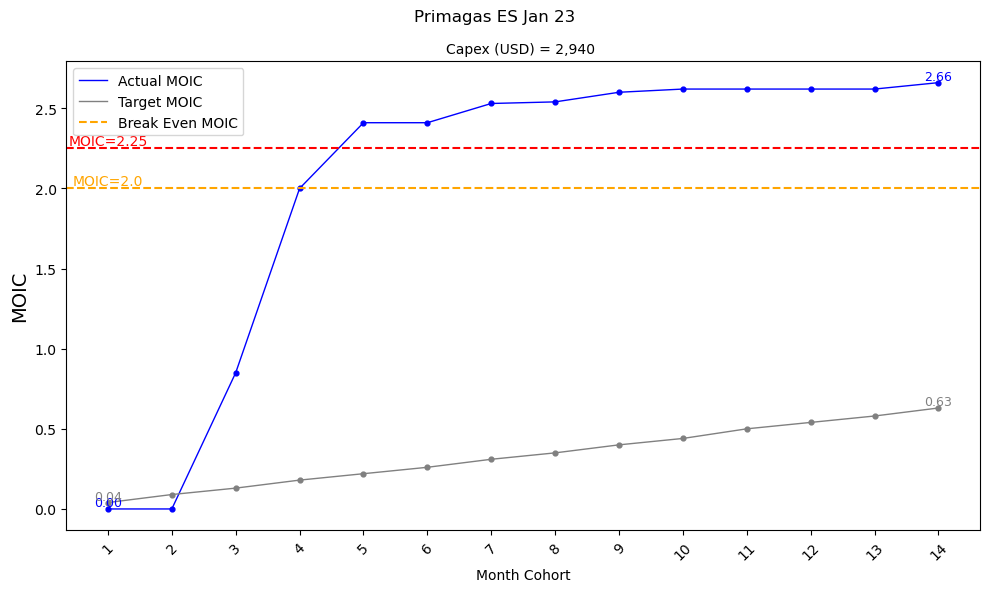

In [176]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', s=12)
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks for only the selected range
ticks = df_cf['month_cohort'][:num_values]
plt.xticks(ticks, rotation=45)

# Annotate last point with its y-value within the limited range
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['moic'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate target MOIC last point within the limited range
last_y_target = df_cf['moic_target'][:num_values].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Annotate target MOIC first point
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()


In [177]:
### MOIC Break even target

monthly_payments = round(df_cf['target_prediction_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []


df_loan_target=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan_target = pd.DataFrame(data)


first_negative_balance_target = df_loan_target[df_loan_target["remaining_balance"] < 0].iloc[0]

first_negative_balance_cohort_month_target = int(first_negative_balance_target["cohort_month"])
moic_break_even_target = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month_target, 'moic_target'].values[0]

print('cohort month moic break even target: ',first_negative_balance_cohort_month_target )
print('value of moic break even target: ',moic_break_even_target)

cohort month moic break even target:  46
value of moic break even target:  1.68


## Pagantis ES Sep 2023

In [48]:
###Manual:
book_id='5176948179'
num_values=10 #amount cohort with actual

In [49]:

query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,coalesce(round(sum(actual_amount),2),0) actual_amount, coalesce(round(sum(actual_amount_usd),2),0) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null -- and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

####Calculting IRR
df_irr_actual=df_cf['actual_amount'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    new_list = df_irr_actual[:i] + df_irr_target[i:]
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly 

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


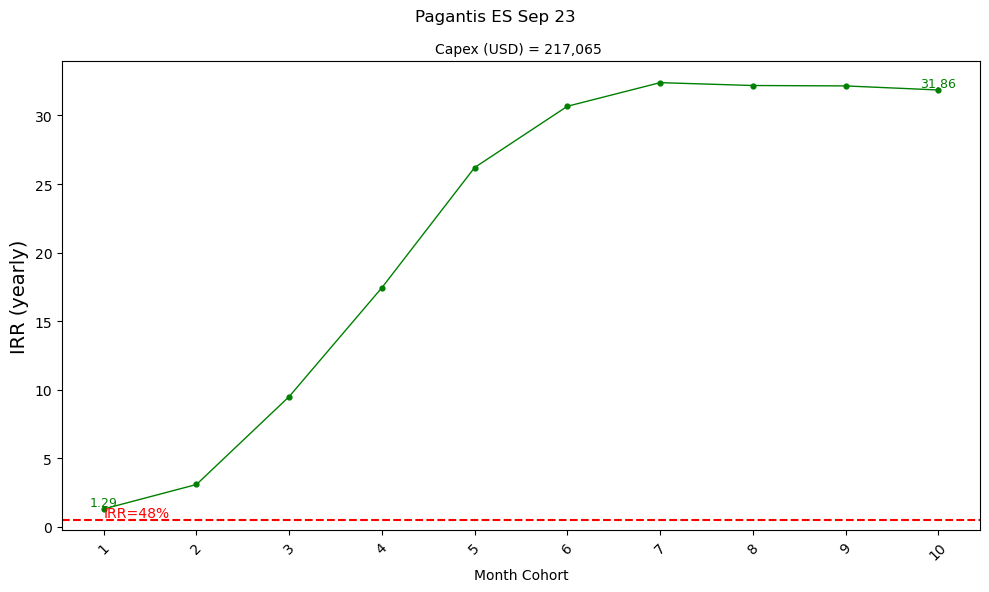

In [50]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('IRR (yearly)', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Rotate x-axis labels for better readability (optional)
plt.xticks(df_cf['month_cohort'][:num_values], rotation=45)

# Annotate each point with its y-value (optional)
# for i, value in enumerate(df_cf['irr_yearly'][:num_values]):
#     plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#              f'{value:,.2f}', ha='center', va='bottom', fontsize=9)

# Get the last value within the limited range for annotation
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['irr_yearly'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
#plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
#plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)

# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48 * 1E-2, color='red', linestyle='--', label='y = 3.32%')
plt.text(df_cf['month_cohort'].min(), 48 * 1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


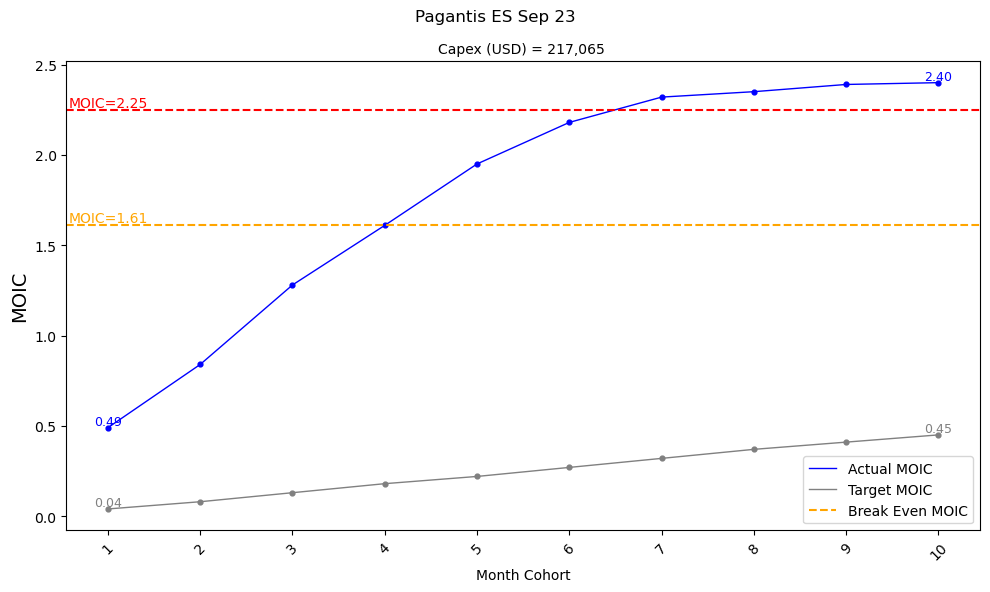

In [51]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', s=12)
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks for only the selected range
ticks = df_cf['month_cohort'][:num_values]
plt.xticks(ticks, rotation=45)

# Annotate last point with its y-value within the limited range
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['moic'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate target MOIC last point within the limited range
last_y_target = df_cf['moic_target'][:num_values].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Annotate target MOIC first point
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()


In [52]:
### MOIC Break even target

monthly_payments = round(df_cf['target_prediction_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []


df_loan_target=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan_target = pd.DataFrame(data)


first_negative_balance_target = df_loan_target[df_loan_target["remaining_balance"] < 0].iloc[0]

first_negative_balance_cohort_month_target = int(first_negative_balance_target["cohort_month"])
moic_break_even_target = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month_target, 'moic_target'].values[0]

print('cohort month moic break even target: ',first_negative_balance_cohort_month_target )
print('value of moic break even target: ',moic_break_even_target)

cohort month moic break even target:  46
value of moic break even target:  1.69


## IPF AU Sep 2023

In [54]:
###Manual:
book_id='5152696966'
num_values=11 #amount cohort with actual

In [55]:
query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,coalesce(round(sum(actual_amount),2),0) actual_amount, coalesce(round(sum(actual_amount_usd),2),0) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null -- and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

####Calculting IRR
df_irr_actual=df_cf['actual_amount'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    new_list = df_irr_actual[:i] + df_irr_target[i:]
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly 

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


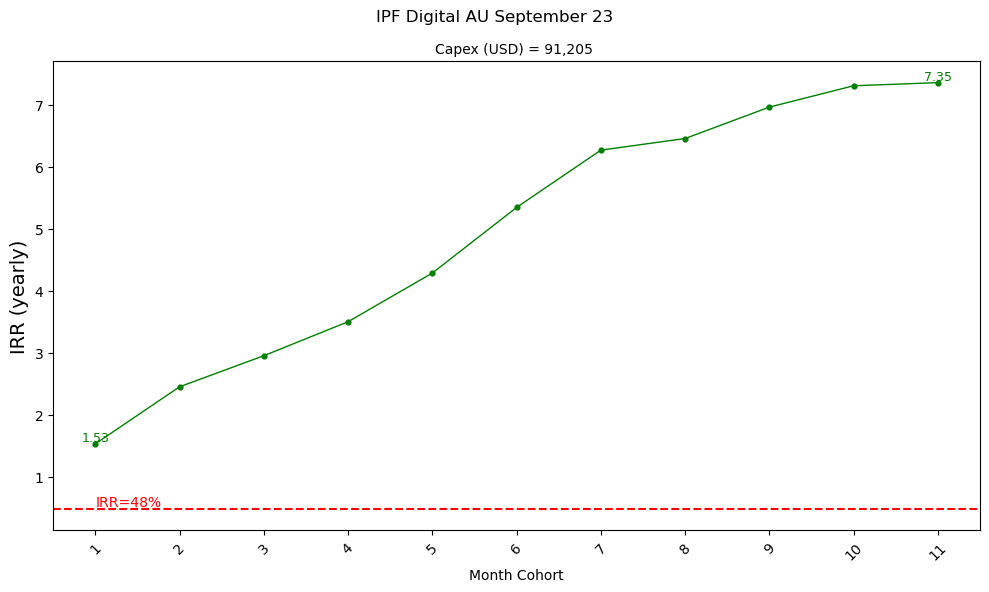

In [56]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('IRR (yearly)', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Rotate x-axis labels for better readability (optional)
plt.xticks(df_cf['month_cohort'][:num_values], rotation=45)

# Annotate each point with its y-value (optional)
# for i, value in enumerate(df_cf['irr_yearly'][:num_values]):
#     plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#              f'{value:,.2f}', ha='center', va='bottom', fontsize=9)

# Get the last value within the limited range for annotation
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['irr_yearly'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
#plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
#plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)

# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48 * 1E-2, color='red', linestyle='--', label='y = 3.32%')
plt.text(df_cf['month_cohort'].min(), 48 * 1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


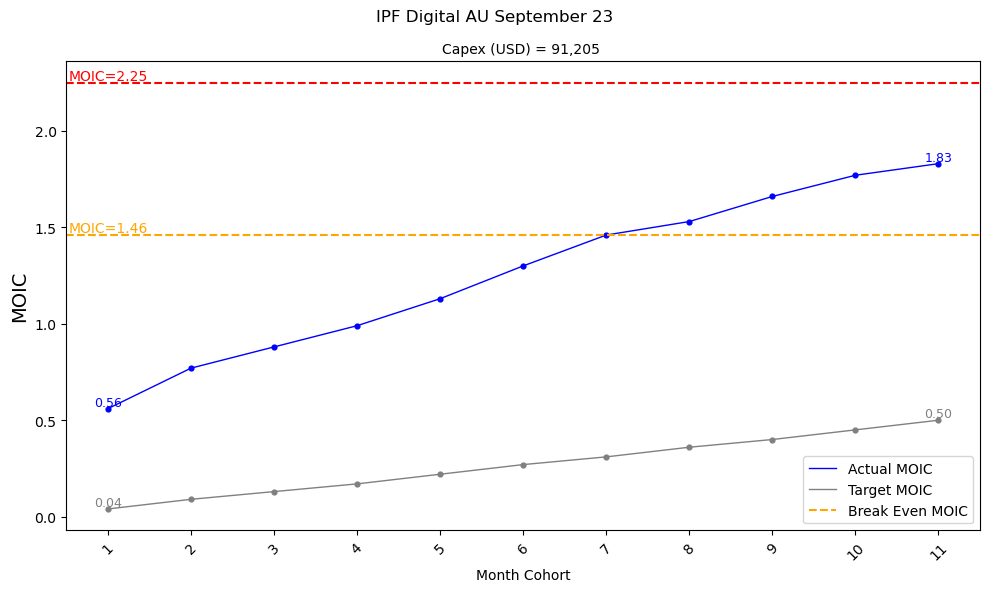

In [57]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', s=12)
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks for only the selected range
ticks = df_cf['month_cohort'][:num_values]
plt.xticks(ticks, rotation=45)

# Annotate last point with its y-value within the limited range
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['moic'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate target MOIC last point within the limited range
last_y_target = df_cf['moic_target'][:num_values].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Annotate target MOIC first point
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()


In [58]:
### MOIC Break even target

monthly_payments = round(df_cf['target_prediction_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []


df_loan_target=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan_target = pd.DataFrame(data)


first_negative_balance_target = df_loan_target[df_loan_target["remaining_balance"] < 0].iloc[0]

first_negative_balance_cohort_month_target = int(first_negative_balance_target["cohort_month"])
moic_break_even_target = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month_target, 'moic_target'].values[0]

print('cohort month moic break even target: ',first_negative_balance_cohort_month_target )
print('value of moic break even target: ',moic_break_even_target)

cohort month moic break even target:  46
value of moic break even target:  1.68


## Elysian Energy AU Aug 2023

In [60]:
###Manual:
book_id='5010243505'
num_values=12 #amount cohort with actual

In [61]:

query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,coalesce(round(sum(actual_amount),2),0) actual_amount, coalesce(round(sum(actual_amount_usd),2),0) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null -- and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

####Calculting IRR
df_irr_actual=df_cf['actual_amount'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    new_list = df_irr_actual[:i] + df_irr_target[i:]
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly 

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


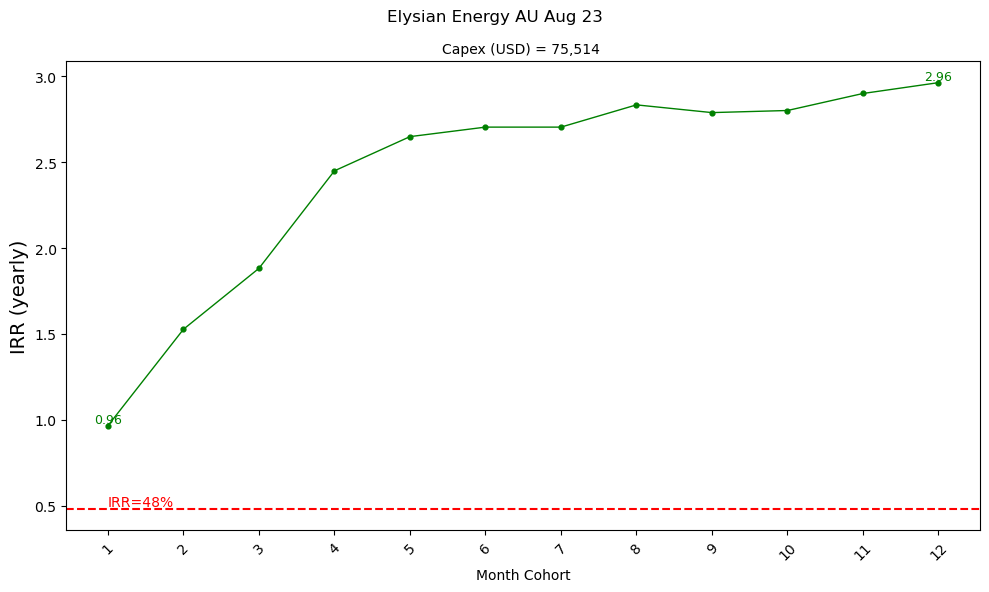

In [62]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('IRR (yearly)', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Rotate x-axis labels for better readability (optional)
plt.xticks(df_cf['month_cohort'][:num_values], rotation=45)

# Annotate each point with its y-value (optional)
# for i, value in enumerate(df_cf['irr_yearly'][:num_values]):
#     plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#              f'{value:,.2f}', ha='center', va='bottom', fontsize=9)

# Get the last value within the limited range for annotation
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['irr_yearly'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
#plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
#plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)

# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48 * 1E-2, color='red', linestyle='--', label='y = 3.32%')
plt.text(df_cf['month_cohort'].min(), 48 * 1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


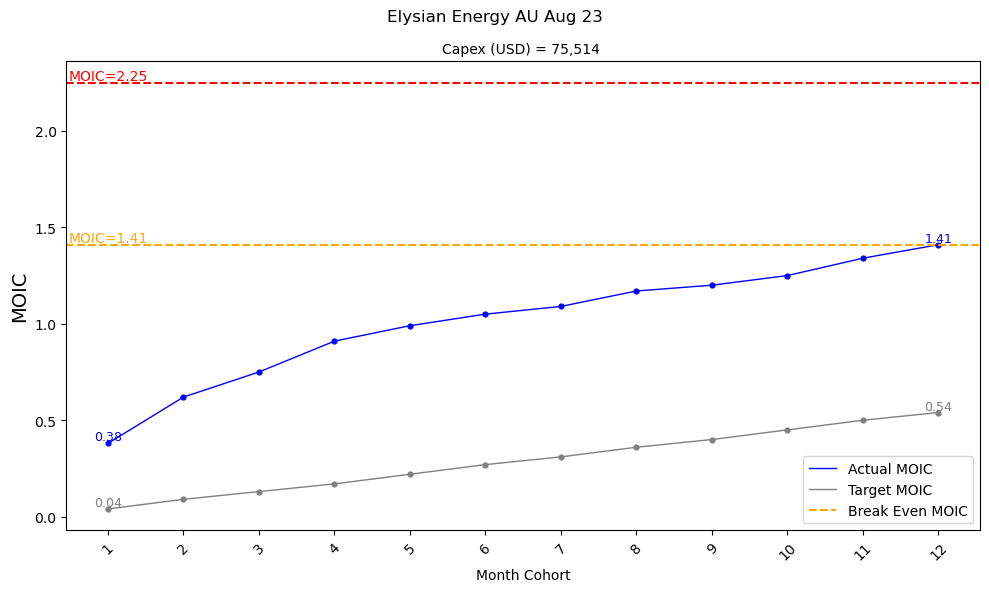

In [63]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', s=12)
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks for only the selected range
ticks = df_cf['month_cohort'][:num_values]
plt.xticks(ticks, rotation=45)

# Annotate last point with its y-value within the limited range
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['moic'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate target MOIC last point within the limited range
last_y_target = df_cf['moic_target'][:num_values].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Annotate target MOIC first point
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()


In [64]:
### MOIC Break even target

monthly_payments = round(df_cf['target_prediction_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []


df_loan_target=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan_target = pd.DataFrame(data)


first_negative_balance_target = df_loan_target[df_loan_target["remaining_balance"] < 0].iloc[0]

first_negative_balance_cohort_month_target = int(first_negative_balance_target["cohort_month"])
moic_break_even_target = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month_target, 'moic_target'].values[0]

print('cohort month moic break even target: ',first_negative_balance_cohort_month_target )
print('value of moic break even target: ',moic_break_even_target)

cohort month moic break even target:  46
value of moic break even target:  1.68


## Axactor ES Jul 2023

In [66]:
###Manual:
book_id='4206843141'
num_values=14 #amount cohort with actual

In [67]:
###this book didn't achieve break even on moic
### Verification: if df_loan['remaining_balance'].tail(1) is positive -> moic break even is not reached

In [68]:

query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,coalesce(round(sum(actual_amount),2),0) actual_amount, coalesce(round(sum(actual_amount_usd),2),0) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null -- and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

#first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
#first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
#moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

####Calculting IRR
df_irr_actual=df_cf['actual_amount'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    new_list = df_irr_actual[:i] + df_irr_target[i:]
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly 

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


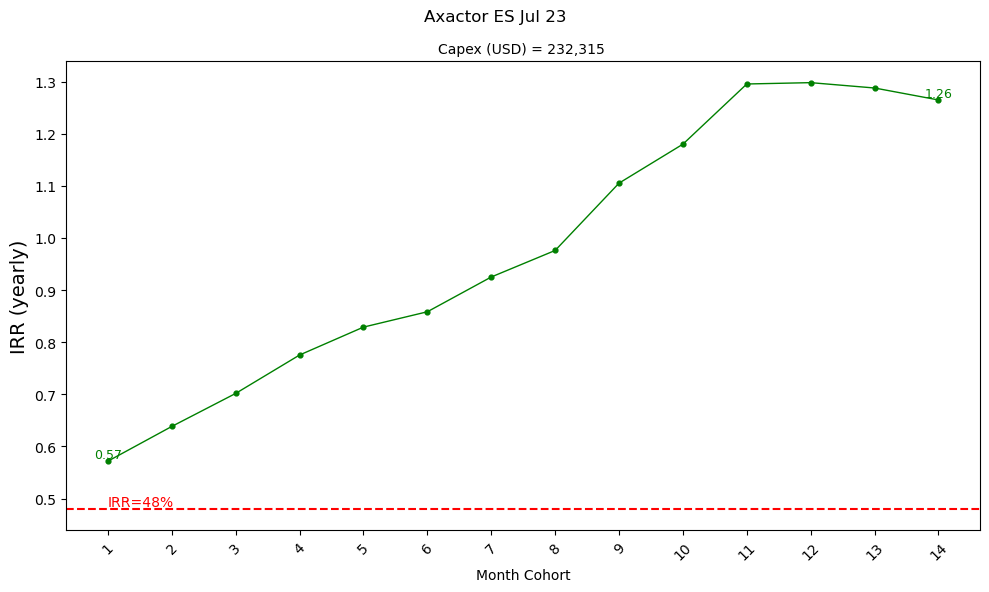

In [69]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('IRR (yearly)', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Rotate x-axis labels for better readability (optional)
plt.xticks(df_cf['month_cohort'][:num_values], rotation=45)

# Annotate each point with its y-value (optional)
# for i, value in enumerate(df_cf['irr_yearly'][:num_values]):
#     plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#              f'{value:,.2f}', ha='center', va='bottom', fontsize=9)

# Get the last value within the limited range for annotation
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['irr_yearly'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
#plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
#plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)

# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48 * 1E-2, color='red', linestyle='--', label='y = 3.32%')
plt.text(df_cf['month_cohort'].min(), 48 * 1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


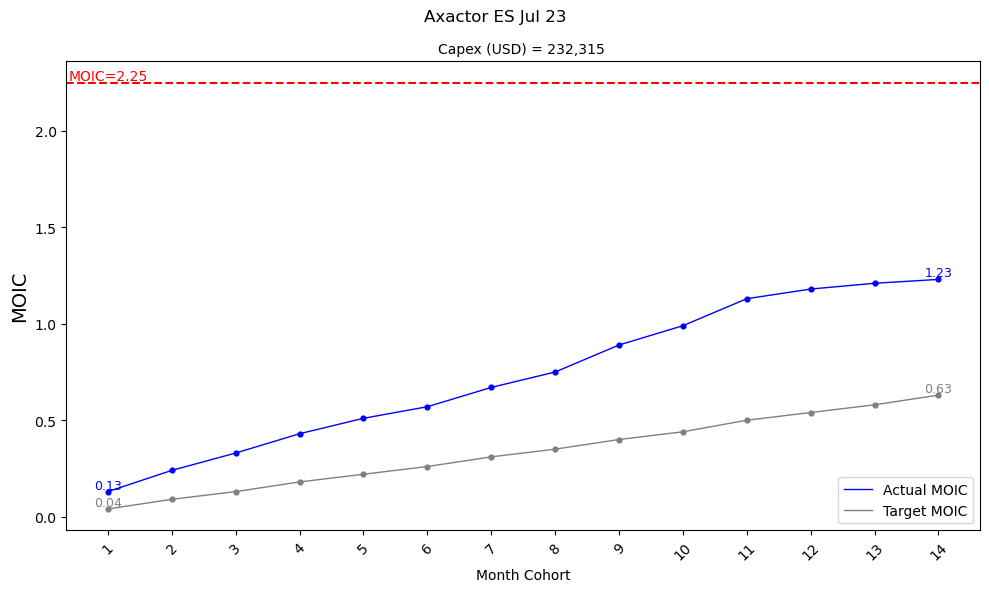

In [70]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', s=12)
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks for only the selected range
ticks = df_cf['month_cohort'][:num_values]
plt.xticks(ticks, rotation=45)

# Annotate last point with its y-value within the limited range
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['moic'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate target MOIC last point within the limited range
last_y_target = df_cf['moic_target'][:num_values].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Annotate target MOIC first point
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
#plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
#plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()


In [71]:
### MOIC Break even target

monthly_payments = round(df_cf['target_prediction_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []


df_loan_target=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan_target = pd.DataFrame(data)


first_negative_balance_target = df_loan_target[df_loan_target["remaining_balance"] < 0].iloc[0]

first_negative_balance_cohort_month_target = int(first_negative_balance_target["cohort_month"])
moic_break_even_target = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month_target, 'moic_target'].values[0]

print('cohort month moic break even target: ',first_negative_balance_cohort_month_target )
print('value of moic break even target: ',moic_break_even_target)

cohort month moic break even target:  46
value of moic break even target:  1.68


## Dineo ES Aug 2022

In [73]:
###Manual:
book_id='3526243721'
num_values=24 #amount cohort with actual

In [74]:
###this book didn't achieve break even on moic.
### Verification: if df_loan['remaining_balance'].tail(1) is positive -> moic break even is not reached

In [75]:
query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,coalesce(round(sum(actual_amount),2),0) actual_amount, coalesce(round(sum(actual_amount_usd),2),0) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null -- and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

#first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
#first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
#moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

####Calculting IRR
df_irr_actual=df_cf['actual_amount'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    new_list = df_irr_actual[:i] + df_irr_target[i:]
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly 

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


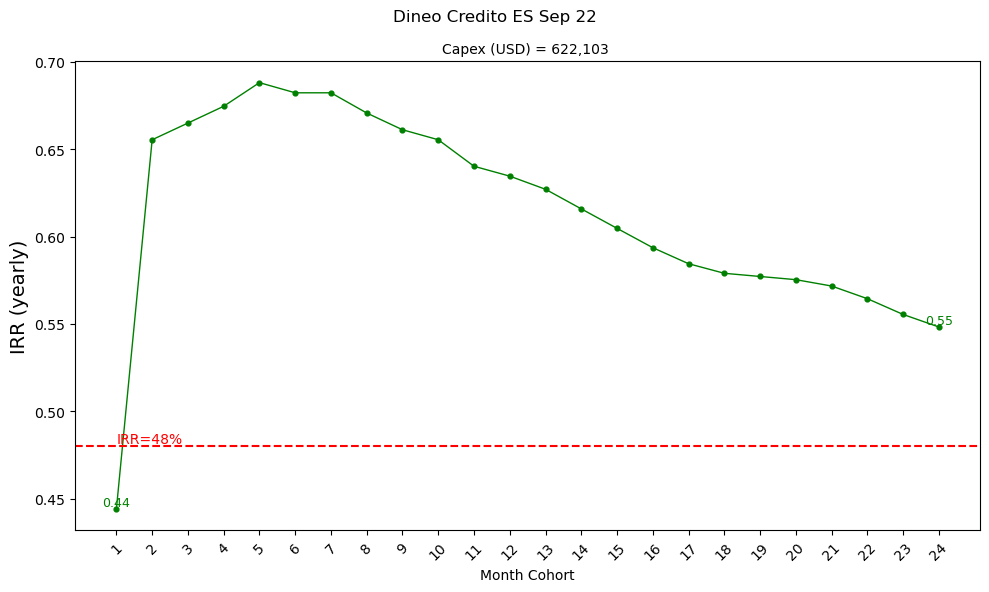

In [76]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('IRR (yearly)', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Rotate x-axis labels for better readability (optional)
plt.xticks(df_cf['month_cohort'][:num_values], rotation=45)

# Annotate each point with its y-value (optional)
# for i, value in enumerate(df_cf['irr_yearly'][:num_values]):
#     plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#              f'{value:,.2f}', ha='center', va='bottom', fontsize=9)

# Get the last value within the limited range for annotation
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['irr_yearly'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
#plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
#plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)

# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48 * 1E-2, color='red', linestyle='--', label='y = 3.32%')
plt.text(df_cf['month_cohort'].min(), 48 * 1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


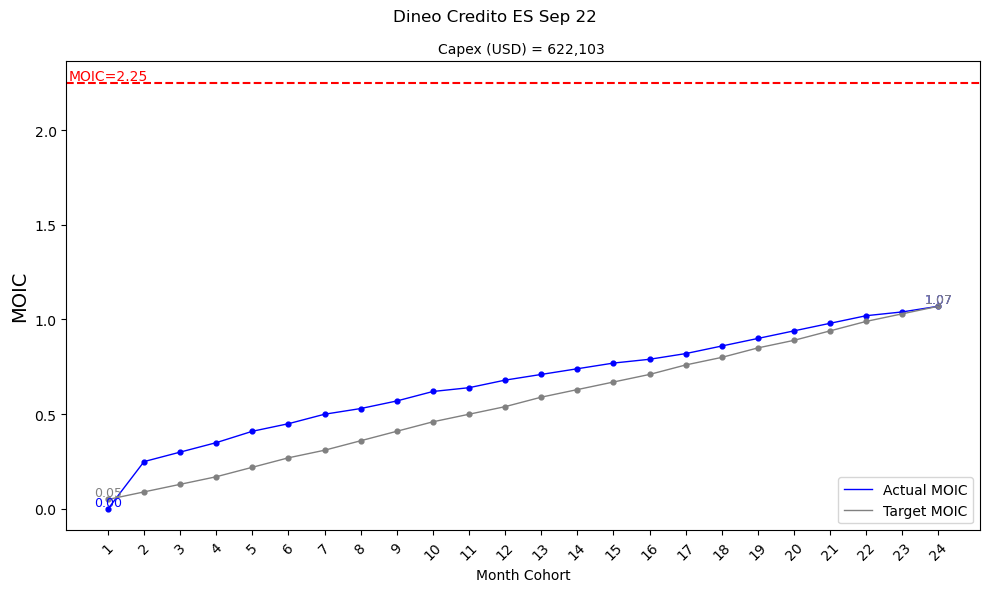

In [77]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', s=12)
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks for only the selected range
ticks = df_cf['month_cohort'][:num_values]
plt.xticks(ticks, rotation=45)

# Annotate last point with its y-value within the limited range
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['moic'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate target MOIC last point within the limited range
last_y_target = df_cf['moic_target'][:num_values].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Annotate target MOIC first point
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
#plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
#plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()


In [78]:
### MOIC Break even target

monthly_payments = round(df_cf['target_prediction_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []


df_loan_target=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan_target = pd.DataFrame(data)


first_negative_balance_target = df_loan_target[df_loan_target["remaining_balance"] < 0].iloc[0]

first_negative_balance_cohort_month_target = int(first_negative_balance_target["cohort_month"])
moic_break_even_target = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month_target, 'moic_target'].values[0]

print('cohort month moic break even target: ',first_negative_balance_cohort_month_target )
print('value of moic break even target: ',moic_break_even_target)

cohort month moic break even target:  46
value of moic break even target:  1.69


## Sumo Energy AU Jul 2024 (Pre DCA)

In [80]:
###Manual:
book_id='6977655973'
num_values=1

In [81]:
###this book didn't achieve break even on moic
### Verification: if df_loan['remaining_balance'].tail(1) is positive -> moic break even is not reached

In [82]:


query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,coalesce(round(sum(actual_amount),2),0) actual_amount, coalesce(round(sum(actual_amount_usd),2),0) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null -- and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

#first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
#first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
#moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

####Calculting IRR
df_irr_actual=df_cf['actual_amount'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    new_list = df_irr_actual[:i] + df_irr_target[i:]
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly 

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


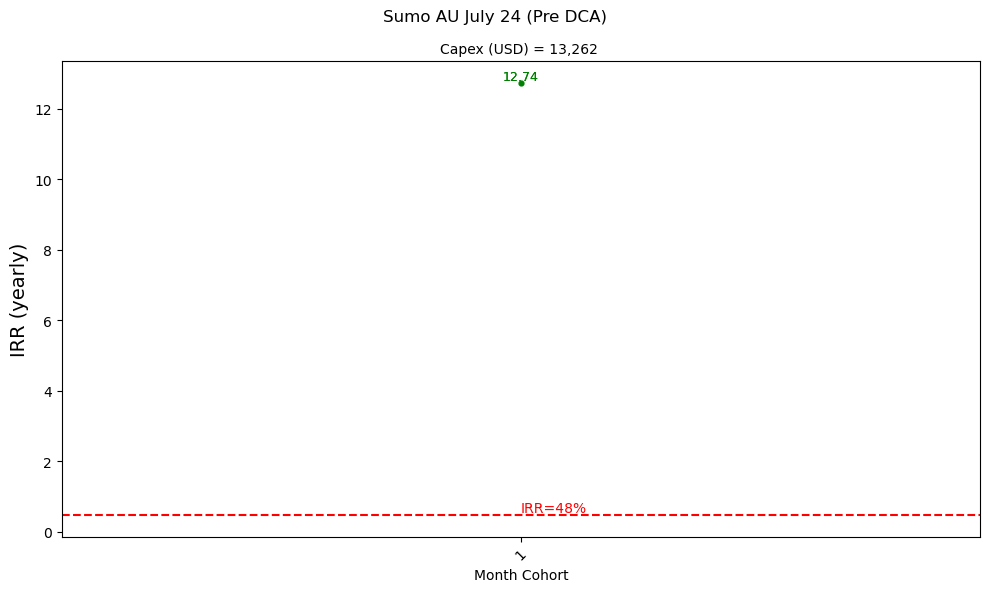

In [83]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('IRR (yearly)', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Rotate x-axis labels for better readability (optional)
plt.xticks(df_cf['month_cohort'][:num_values], rotation=45)

# Annotate each point with its y-value (optional)
# for i, value in enumerate(df_cf['irr_yearly'][:num_values]):
#     plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#              f'{value:,.2f}', ha='center', va='bottom', fontsize=9)

# Get the last value within the limited range for annotation
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['irr_yearly'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
#plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
#plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)

# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48 * 1E-2, color='red', linestyle='--', label='y = 3.32%')
plt.text(df_cf['month_cohort'].min(), 48 * 1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


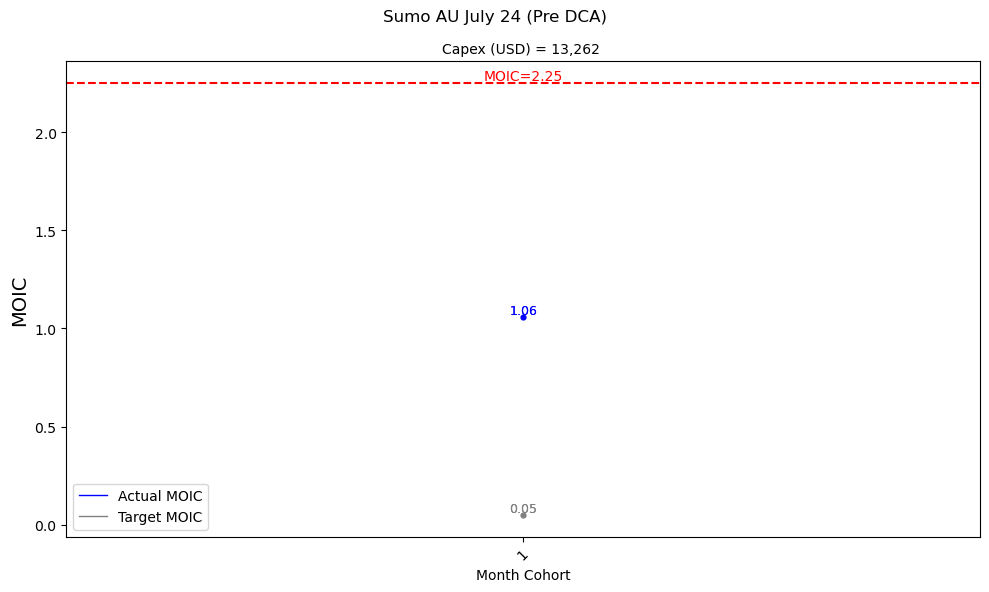

In [84]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', s=12)
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks for only the selected range
ticks = df_cf['month_cohort'][:num_values]
plt.xticks(ticks, rotation=45)

# Annotate last point with its y-value within the limited range
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['moic'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate target MOIC last point within the limited range
last_y_target = df_cf['moic_target'][:num_values].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Annotate target MOIC first point
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
#plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
#plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()


In [85]:
### MOIC Break even target

monthly_payments = round(df_cf['target_prediction_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []


df_loan_target=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan_target = pd.DataFrame(data)


first_negative_balance_target = df_loan_target[df_loan_target["remaining_balance"] < 0].iloc[0]

first_negative_balance_cohort_month_target = int(first_negative_balance_target["cohort_month"])
moic_break_even_target = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month_target, 'moic_target'].values[0]

print('cohort month moic break even target: ',first_negative_balance_cohort_month_target )
print('value of moic break even target: ',moic_break_even_target)

cohort month moic break even target:  46
value of moic break even target:  1.68
